# analyze `allblocks-tobalaba.db` data; better node connectivity

calculates & plots

* blocktime
* TPS (transactions per second), over 1, 3, 5, 10 consecutive blocks
* block size
* gasUsed and gasLimit per second

It needs an `allblocks-tobalaba.db` database (created by `blocksDB_create.py`) containing all the blocks.


In this specific case the `Tobalaba` chain of the Energy Web Foundation (https://tobalaba.etherscan.com).

---
### new version v20 = refactored into `blocksDB_diagramming.py`


Please cite this as:

> Ethereum benchmarking scripts "chainhammer" and "chainreader"  
> by Dr Andreas Krueger, Electron.org.uk, London 2018  
> https://github.com/drandreaskrueger/chainhammer    

Consider to submit your improvements & usage as pull request --> [../other-projects.md](../other-projects.md).  Thanks.


## analyzing the whole Tobalaba Chain
    




## TOC

Code 

* [import from database](#Database)
* [simple statistics](#stats)
* [generate new columns](#columns)
* [4 diagrams in one](#code4diagrams)

Results

* whole chain
* whole chain, log TPS plot
* zoom 1
* zoom 2



<a id='database'>Database</a>

In [ ]:
# Settings

DBFILE="allblocks-tobalaba.db"
RAFT = False
NAME_PREFIX="tobalaba"


In [ ]:
#dependencies

import sqlite3; print("sqlite3 version", sqlite3.version)
import pandas; print("pandas version", pandas.__version__)
import numpy; print("numpy version", numpy.__version__)
import matplotlib; print("matplotlib version", matplotlib.__version__)
print()
# allows to reload when external python code changed:
%load_ext autoreload
%reload_ext autoreload
%autoreload 1

from blocksDB_diagramming import DB_query, DB_tableSize, maxBlockNumber, check_whether_complete
from blocksDB_diagramming import add_blocktime, add_TPS, add_GUPS, add_GLPS, diagrams

%matplotlib inline

# https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
matplotlib.rcParams['agg.path.chunksize'] = 10000

print ("\nWill be reading blocks table from", DBFILE)

sqlite3 version 2.6.0
pandas version 0.23.0
numpy version 1.14.4
matplotlib version 2.2.2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Will be reading blocks table from allblocks-tobalaba.db


### READ Database

In [ ]:
# open database connection
conn = sqlite3.connect(DBFILE)

# DB table names
print ("DB table names: ", DB_query("SELECT name FROM sqlite_master WHERE type='table';", conn)[0])

# number of rows?
_=DB_tableSize("blocks", conn)

# what is the first & last block we have?
minblock, maxblock = maxBlockNumber(conn)[0]

# how many
blocknumbers = DB_query("SELECT blocknumber FROM blocks ORDER BY blocknumber", conn) 
print ("len(blocknumbers)=", len(blocknumbers))

# do we have consecutive blocks, none missing?
check_whether_complete(blocknumbers)

DB table names:  ('blocks',)
TABLE blocks has 5173723 rows
MIN(blocknumber), MAX(blocknumber) = [(0, 5173722)] 
len(blocknumbers)= 5173723

complete between blocks 0 and 5173722.


<a id='stats'>simple statistics</a>

In [ ]:
# simple statistics

size_max = DB_query("SELECT MAX(size) FROM blocks", conn); print ("(block)size_max", size_max[0][0])
txcount_max = DB_query("SELECT MAX(txcount) FROM blocks", conn); print ("txcount_max", txcount_max[0][0])
txcount_av = DB_query("SELECT AVG(txcount) FROM blocks", conn); print ("txcount_av", txcount_av[0][0])
txcount_sum = DB_query("SELECT SUM(txcount) FROM blocks", conn); print ("txcount_sum", txcount_sum[0][0])
blocks_nonempty_count = DB_query("SELECT COUNT(blocknumber) FROM blocks WHERE txcount != 0", conn); print ("blocks_nonempty_count", blocks_nonempty_count[0][0])
print ("av tx per nonempty blocks = ", txcount_sum[0][0] / blocks_nonempty_count[0][0] )

(block)size_max 420255
txcount_max 2994
txcount_av 0.7909907430297293
txcount_sum 4092367
blocks_nonempty_count 2516368
av tx per nonempty blocks =  1.626299094568044


<a id='colums'>new columns</a>
## read whole table, and create new columns

In [ ]:
# read whole table

# SQL="SELECT * FROM blocks WHERE 48500<blocknumber and blocknumber<49000 ORDER BY blocknumber"
SQL="SELECT * FROM blocks ORDER BY blocknumber"
df = pandas.read_sql(SQL, conn)

In [ ]:
conn.close()

### RAFT consensus returns a nanosecond timestamp ???

In [ ]:
# quorum raft uses nanoseconds, not seconds --> transform nanoseconds to seconds
if RAFT:
    df["timestamp"]=df["timestamp"]/1000000000
    print ("corrected timestamps because RAFT")
df[:6]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount
0,0,0,533,0,8388608,0
1,1,1509488585,560,0,8380417,0
2,2,1509488589,560,0,8372234,0
3,3,1509488592,560,0,8364059,0
4,4,1509488594,560,0,8355892,0
5,5,1509488597,560,0,8347733,0


# generate columns:

In [ ]:
# blocktime = timestamp[n] - timestamp[n-1]

add_blocktime(df)
df[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime
0,0,0,533,0,8388608,0,NaN
1,1,1509488585,560,0,8380417,0,NaN
2,2,1509488589,560,0,8372234,0,4.0
3,3,1509488592,560,0,8364059,0,3.0
4,4,1509488594,560,0,8355892,0,2.0
5,5,1509488597,560,0,8347733,0,3.0
6,6,1509488600,560,0,8339582,0,3.0
7,7,1509488603,560,0,8331439,0,3.0
8,8,1509488607,560,0,8323304,0,4.0
9,9,1509488610,560,0,8315177,0,3.0


In [ ]:
#df["TPS_1"]=df['txcount']/df['blocktime']
#df

In [ ]:
# transactions per second
# with differently sized (rectangular) windows

add_TPS(df, numBlocks=1)
add_TPS(df, numBlocks=3)
add_TPS(df, numBlocks=5)
add_TPS(df, numBlocks=10)

In [ ]:
# gasUsed and gasLimit per second

add_GUPS(df, numBlocks=1)
add_GUPS(df, numBlocks=3)
add_GUPS(df, numBlocks=5)

add_GLPS(df, numBlocks=1)
add_GLPS(df, numBlocks=3)
add_GLPS(df, numBlocks=5)

<a id='tables'>tables of peak TPS rates</a>
## peak TPS rates

In [ ]:
# peak TPS single block

df.sort_values(by=['TPS_1blk'], ascending=False)[0:7]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
5172088,5172088,1530010215,416760,79911135,80000000,2994,3.0,998.000000,397.133333,293.952381,209.850000,2.663704e+07,1.059955e+07,7.845483e+06,2.666667e+07,1.600000e+07,1.904762e+07
5173610,5173610,1530015930,416709,79912854,80000000,2994,3.0,998.000000,199.933333,204.666667,119.761905,2.663762e+07,5.336090e+06,5.462413e+06,2.666667e+07,1.600000e+07,1.666667e+07
4997301,4997301,1529330700,406463,77936065,80000000,2920,3.0,973.333333,324.888889,162.611111,75.128205,2.597869e+07,8.670874e+06,4.339702e+06,2.666667e+07,2.666667e+07,2.222222e+07
5173637,5173637,1530016029,325523,62403558,79999923,2338,3.0,779.333333,259.888889,178.333333,74.500000,2.080119e+07,6.936510e+06,4.760560e+06,2.666664e+07,2.665798e+07,2.666145e+07
5173656,5173656,1530016111,419721,79912854,80000000,2994,4.0,748.500000,192.437500,140.045455,140.883721,1.997821e+07,5.136035e+06,3.737574e+06,2.000000e+07,1.500000e+07,1.818182e+07
5173658,5173658,1530016119,420255,79912854,79999923,2994,4.0,748.500000,499.083333,253.083333,156.422222,1.997821e+07,1.332090e+07,6.754769e+06,1.999998e+07,1.999348e+07,1.666341e+07
5172043,5172043,1530010044,295368,56611611,79999923,2121,3.0,707.000000,236.000000,178.600000,74.611111,1.887054e+07,6.298892e+06,4.767677e+06,2.666664e+07,2.665798e+07,2.666145e+07


In [ ]:
# peak TPS over ten blocks

df.sort_values(by=['TPS_10blks'], ascending=False)[0:7]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
5173614,5173614,1530015942,86779,16546765,80000000,620,3.0,206.666667,297.000000,518.533333,248.666667,5.515588e+06,7.927043e+06,1.383995e+07,2.666667e+07,2.665798e+07,2.666145e+07
5172091,5172091,1530010224,225176,43132656,79999923,1616,3.0,538.666667,179.666667,321.466667,245.638889,1.437755e+07,4.795299e+06,8.579932e+06,2.666664e+07,2.665798e+07,2.666145e+07
5172092,5172092,1530010227,741,25036,80000000,1,3.0,0.333333,179.666667,307.466667,245.611111,8.345333e+03,4.795299e+06,8.206258e+06,2.666667e+07,2.665798e+07,2.666145e+07
5173619,5173619,1530015960,741,25036,80000000,1,3.0,0.333333,8.333333,11.333333,241.878788,8.345333e+03,2.218733e+05,3.019463e+05,2.666667e+07,2.666667e+07,2.222222e+07
5173618,5173618,1530015957,741,25036,80000000,1,3.0,0.333333,20.555556,45.722222,241.878788,8.345333e+03,5.479128e+05,1.219820e+06,2.666667e+07,2.666667e+07,2.222222e+07
5173615,5173615,1530015948,3104,478783,80000000,18,6.0,3.000000,224.250000,266.777778,231.285714,7.979717e+04,5.985181e+06,7.120290e+06,1.333333e+07,1.999999e+07,2.221788e+07
5173646,5173646,1530016068,881,51727,80000000,2,3.0,0.666667,294.666667,287.791667,225.190476,1.724233e+04,7.864669e+06,7.681100e+06,2.666667e+07,1.333333e+07,1.666667e+07


In [ ]:
# peak size over ten blocks

df.sort_values(by=['size'], ascending=False)[0:5]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
5173658,5173658,1530016119,420255,79912854,79999923,2994,4.0,748.500000,499.083333,253.083333,156.422222,1.997821e+07,1.332090e+07,6.754769e+06,1.999998e+07,19993483.25,1.666341e+07
5173656,5173656,1530016111,419721,79912854,80000000,2994,4.0,748.500000,192.437500,140.045455,140.883721,1.997821e+07,5.136035e+06,3.737574e+06,2.000000e+07,15000000.00,1.818182e+07
5172088,5172088,1530010215,416760,79911135,80000000,2994,3.0,998.000000,397.133333,293.952381,209.850000,2.663704e+07,1.059955e+07,7.845483e+06,2.666667e+07,16000000.00,1.904762e+07
5173610,5173610,1530015930,416709,79912854,80000000,2994,3.0,998.000000,199.933333,204.666667,119.761905,2.663762e+07,5.336090e+06,5.462413e+06,2.666667e+07,16000000.00,1.666667e+07
4993735,4993735,1529316789,409916,78604995,80000000,2945,9.0,327.222222,196.466667,143.095238,77.153846,8.733888e+06,5.243671e+06,3.819675e+06,8.888889e+06,16000000.00,1.904762e+07


<a id='code4diagrams'>code: 4 diagrams in one</a>
## all 4 diagrams in one

## whole chain DB

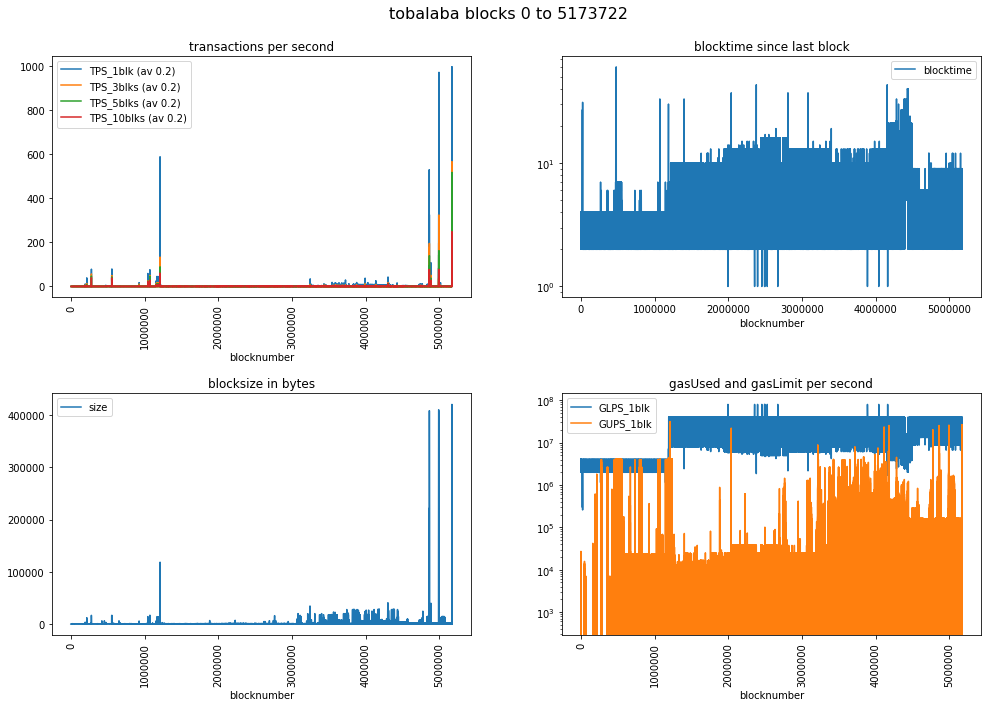

In [ ]:
# the whole range of blocks

diagrams(df, 0, len(blocknumbers)-1, NAME_PREFIX, gas_logy=True, bt_logy=True)

## whole chain DB, TPS plotted logarithmic

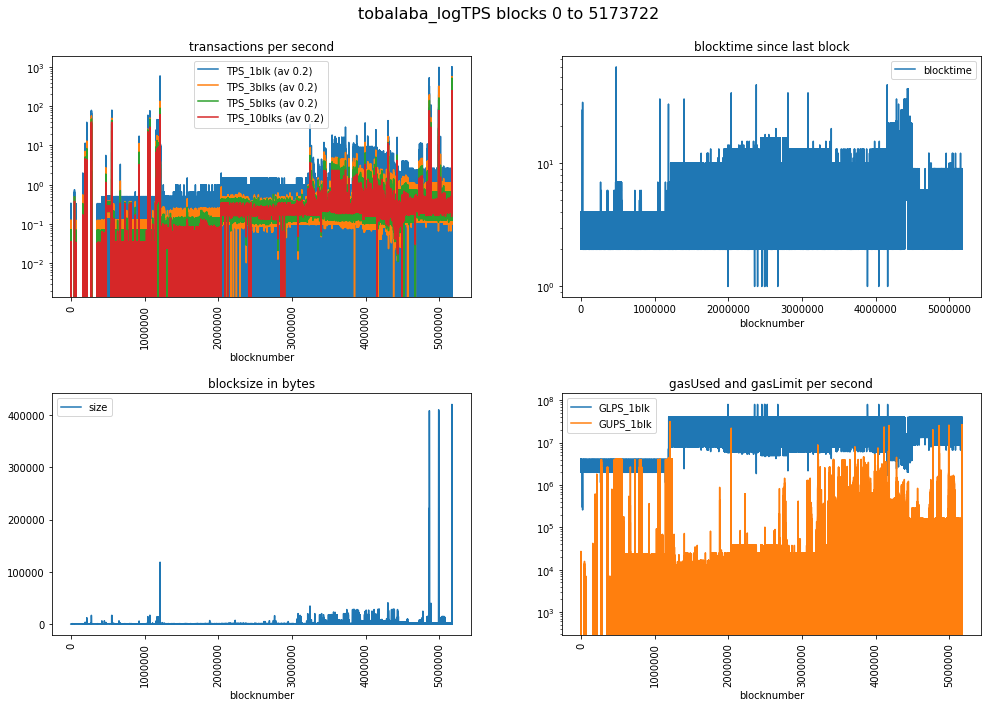

In [ ]:
# the whole range of blocks

diagrams(df, 0, len(blocknumbers)-1, NAME_PREFIX+"_logTPS", gas_logy=True, bt_logy=True, tps_logy=True)

## zooming in
## my own experiment, 10,000 tx in blocks 5172078 ...


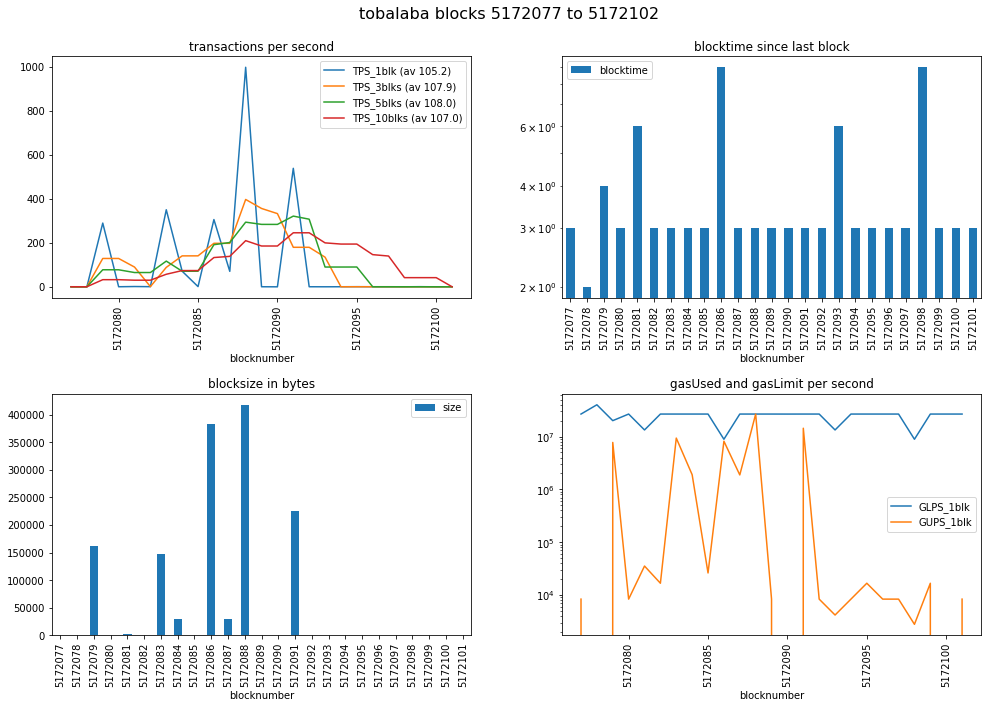

In [ ]:
# zooming in

diagrams(df, 5172077, 5172102, NAME_PREFIX, gas_logy=True, bt_logy=True)

## zooming in
## my own experiment: 20,000 tx in blocks 5173632 ...



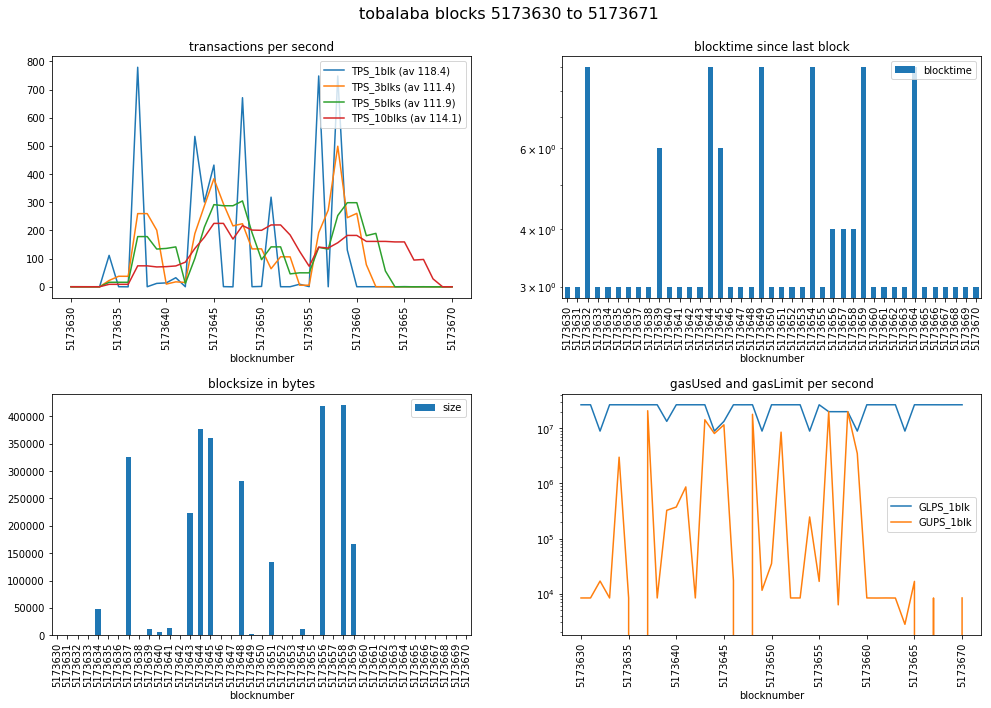

In [ ]:
# zooming in

diagrams(df, 5173630, 5173671, NAME_PREFIX, gas_logy=True, bt_logy=True)